# Topic 38: Time Series Models

- 05/27/21
- onl01-dtsc-ft-022221

## Learning Objectives:

- Introduce time series models.
- Discuss basic time series models/types (white noise, random walk)
- Learn about autocorrelation and seasonality. (PACF, ACF)
- Introduce ARMA/ARIMA and SARIMA models.
    - Deep dive into getting predictions/forecasts. 
- Activity: Modeling Baltimore Crime with statsmodels

## Questions

- Is it possible to run an AR(3,0) model and seeing that Lag 2 was insignificant run an AR model on Lag 1 and Lag 3 (essentially, can you exclude intermediary lags)
- What is the significance of the white noise and random walk models? 
    - Would we run them as 'dummy' models to compare performance of our AR models? Or are these types of time series that we could encounter in real data that can't really be modeled very well?
- Can you talk a little more about interpreting the ACF and PACF plots and how they can help us decide on the right parameters for AR and MA? The sarima lab has us do a grid search… why might we do that if selecting appropriate parameters can be done from looking at the ACF and PACF plots?
- Can you explain whether there is a mathematical reason to shifting/differencing and what they achieve? Shifting/differencing the time series seems a little arbitrary.


# Revisiting Baltimore Crime from Topic 37

In [2]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns 
import numpy as np

from random import gauss

pd.set_option('precision',3)
plt.rcParams['figure.figsize'] = [12,5]


import plotly.express as px
import plotly.io as pio
pio.templates.default = "plotly_dark"

import statsmodels.tsa.api as tsa

In [3]:
## Functions from Last Class 
%load_ext autoreload
%autoreload 2
import ts_functions as tsf

### Loading in Time Series

In [4]:
## Load in file and parse_dates, check index
file = '../topic_37_intro_to_time_series/baltimore_crime_counts_2021.csv'
df = pd.read_csv(file,parse_dates=True, index_col='CrimeDateTime')
display(df.head(),df.index)

,HOMICIDE,AGG. ASSAULT,COMMON ASSAULT,LARCENY,AUTO THEFT,ROBBERY - CARJACKING,BURGLARY,LARCENY FROM AUTO,ROBBERY - COMMERCIAL,SHOOTING,ROBBERY - RESIDENCE,ROBBERY - STREET,ARSON,RAPE
CrimeDateTime,,,,,,,,,,,,,,
2014-01-01 00:00:00+00:00,2,22,19,34,9,0.0,20,15,2,2,1.0,8.0,0.0,5.0
2014-01-02 00:00:00+00:00,3,6,23,26,7,1.0,28,10,1,0,1.0,4.0,0.0,0.0
2014-01-03 00:00:00+00:00,1,11,17,16,3,0.0,13,6,1,1,1.0,2.0,0.0,0.0
2014-01-04 00:00:00+00:00,0,14,23,23,14,0.0,20,15,1,0,1.0,7.0,0.0,0.0
2014-01-05 00:00:00+00:00,0,9,22,19,11,2.0,14,13,0,2,1.0,10.0,0.0,1.0


DatetimeIndex(['2014-01-01 00:00:00+00:00', '2014-01-02 00:00:00+00:00',
               '2014-01-03 00:00:00+00:00', '2014-01-04 00:00:00+00:00',
               '2014-01-05 00:00:00+00:00', '2014-01-06 00:00:00+00:00',
               '2014-01-07 00:00:00+00:00', '2014-01-08 00:00:00+00:00',
               '2014-01-09 00:00:00+00:00', '2014-01-10 00:00:00+00:00',
               ...
               '2021-05-13 00:00:00+00:00', '2021-05-14 00:00:00+00:00',
               '2021-05-15 00:00:00+00:00', '2021-05-16 00:00:00+00:00',
               '2021-05-17 00:00:00+00:00', '2021-05-18 00:00:00+00:00',
               '2021-05-19 00:00:00+00:00', '2021-05-20 00:00:00+00:00',
               '2021-05-21 00:00:00+00:00', '2021-05-22 00:00:00+00:00'],
              dtype='datetime64[ns, UTC]', name='CrimeDateTime', length=2699, freq=None)

> - If data is already in the frequency desired, can use `.resample("D").asfreq()` instead of an aggregation function

In [5]:
## resample.asfreq
df = df.resample('D').asfreq()
df.index

DatetimeIndex(['2014-01-01 00:00:00+00:00', '2014-01-02 00:00:00+00:00',
               '2014-01-03 00:00:00+00:00', '2014-01-04 00:00:00+00:00',
               '2014-01-05 00:00:00+00:00', '2014-01-06 00:00:00+00:00',
               '2014-01-07 00:00:00+00:00', '2014-01-08 00:00:00+00:00',
               '2014-01-09 00:00:00+00:00', '2014-01-10 00:00:00+00:00',
               ...
               '2021-05-13 00:00:00+00:00', '2021-05-14 00:00:00+00:00',
               '2021-05-15 00:00:00+00:00', '2021-05-16 00:00:00+00:00',
               '2021-05-17 00:00:00+00:00', '2021-05-18 00:00:00+00:00',
               '2021-05-19 00:00:00+00:00', '2021-05-20 00:00:00+00:00',
               '2021-05-21 00:00:00+00:00', '2021-05-22 00:00:00+00:00'],
              dtype='datetime64[ns, UTC]', name='CrimeDateTime', length=2699, freq='D')

In [6]:
## Get a list of crimes to remind ourselves what we have
df.sum().sort_values(ascending=False)

LARCENY                 74681.0
COMMON ASSAULT          57451.0
BURGLARY                46935.0
LARCENY FROM AUTO       43223.0
AGG. ASSAULT            38478.0
AUTO THEFT              29502.0
ROBBERY - STREET        23056.0
ROBBERY - COMMERCIAL     5872.0
SHOOTING                 4777.0
ROBBERY - RESIDENCE      3590.0
ROBBERY - CARJACKING     3128.0
HOMICIDE                 2311.0
RAPE                     2236.0
ARSON                    1409.0
dtype: float64

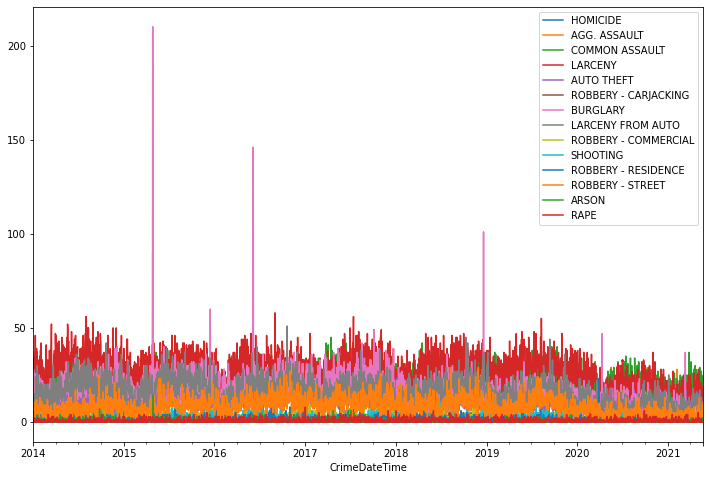

In [7]:
## Plot the weekly dataset to identify which ts to model
ax = df.plot(figsize=(12,8)) 
ax.legend(bbox_to_anchor=[1,1])

> For modeling purposes, we are going to focus on **Weekly crime** forecasts instead of daily, so we will resample to Weekly freq.

In [9]:
## Lets resample the df to Weekly and save as new dfw
# also, let's take 2018 - present for ~3 years of data
dfw = df.resample('W').sum().loc['2017':]

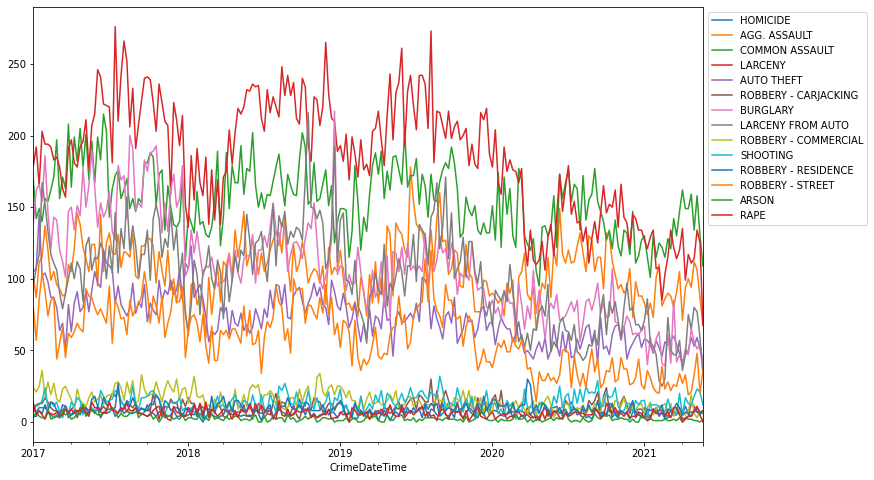

In [10]:
## Plot the weekly dataset to identify which ts to model
ax = dfw.plot(figsize=(12,8)) 
ax.legend(bbox_to_anchor=[1,1])

> #### Theres a lot of lines to sift through so lets use plotly express to make it easier


In [ ]:
# use px.line 


- Before we dive into modeling crime, let's discuss the simplest time series models. 

# Basic Time Series models

## Simplest Time Series Models

- White Noise Model
- Random Walk Model

### White Noise Model
- 3 Properties:
    - Fixed and constant mean
    - Fixed and constant variance
    - No correlation over time

$$\Large Y_t =  \epsilon_t$$

The error term is randomly distributed around the mean, has constant variance, and no autocorrelation.

- Gaussian White Noise: A special case of a White Noise model is 
    - Mean is equal to zero
    - variance is equal to 1
    $$\large Y_t = \epsilon_t + \theta * \epsilon_{t-1}$$

In [ ]:
## White noise has mean=0, variance =1
mean = 0
variance = 1

## Make a white noise time series
noise = pd.Series([gauss(mean, np.sqrt(variance)) for x in range(1000)])
noise.plot(title='White Noise')

## Check our mean and variance
noise.mean(),noise.var()

#### Verify White Noise 

##### From 2015 scipy conference paper https://conference.scipy.org/proceedings/scipy2015/pdfs/margaret_mahan.pdf
- Use windows of 10% to asses white noise

In [ ]:
## Calc 10% of time steps/lags


In [ ]:
## Check if white noise


### Random Walk Model
- Two Properties:
    - Has no specified mean or variance
    - Has a strong dependence over time

- Mathematically, this can be written as:

$$\large Y_t = Y_{t-1} + \epsilon_t$$

- Where $\epsilon_t$ is a *mean zero* white noise model

- Random Walk with a Drift":
    - a drift parameter $c$, steering in a certain direction.
$$\large Y_t = c + Y_{t-1} + \epsilon_t$$

In [ ]:
## Using white noise to simulate a random walk
#https://campus.datacamp.com/courses/time-series-analysis-in-python/some-simple-time-series?ex=7
walk = noise.shift(-1)+noise.cumsum()
walk.plot()

In [ ]:
## Check if random walk is stationary

- When a random walk is differenced it returns a white noise. 

This is a result of the mathematical formula:

$$Y_t = Y_{t-1} + \epsilon_t$$
which is equivalent to
$$Y_t - Y_{t-1} = \epsilon_t$$

and we know that $\epsilon_t$ is a mean-zero white noise process! 

In [ ]:
## Confirm walk differenced returns a white noise


## Finding Basic Time Series in Baltimore Crimes

### Identifying Crimes Optimal for Different Types of Times Series Models


- Using the plotly plot, explore individual crimes to identify which crimes are appropriate for the different types of time series models.
- Then confirm using stationarity check

- White Noise: ___
- Random Walk: ___

In [ ]:
## re-plot dfw and identify crimes that follow a white nosie or random walk model


In [ ]:
### Identifying Crimes Optimal for Different Types of Times Series Models


### Check Our White Noise Crime

In [ ]:
## Visualize white noise-like ts


In [ ]:
## Calculate 10% window and check stationarity


### Check Our Random Walk Crime

In [ ]:
## Visualize random-walk ts


In [ ]:
## Check if our random walk is stationary


In [ ]:
## confirm our random walk becomes stationary white noise


# Correlation, Autocorrelation & Partial Autocorrelation

> Time Series that are correlated with themselves (autocorrelation) are best suited for a more complex modeling approach.

In [ ]:
## Use AGG. ASSAULT as ts 


## Exploring Autocorrelation 

In [ ]:
## Use AGG. ASSAULT as ts and plot


In [ ]:
## Save differenced version and plot
ts_diff = None

In [ ]:
## Shift the ts_orig by -1 time lag


## Plot original ts vs shifted


In [ ]:
## Shift the orig ts from -1 to -52 lags



## Concatenate ts_orig and shifted_ts


In [ ]:
## Plot the correlations 


In [ ]:
## Shift the ts_orig by -1 time lag


## Plot original ts vs shifted


In [ ]:
## Shift the orig ts from -1 to -52 lags



## Concatenate ts_orig and shifted_ts


In [ ]:
## Plot the correlations 



## ACF & PACF  Plots

### Autocorrelation Function Plots

https://machinelearningmastery.com/gentle-introduction-autocorrelation-partial-autocorrelation/

> - "The **autocorrelation function** is a function that represents autocorrelation of a time series as a function of the time lag."
- The autocorrelation function tells interesting stories about trends and seasonality. For example, if the original time series repeats itself every five days, you would expect to see a spike in the autocorrelation function at 5 days.



In [ ]:
## Use panda's autocorrelation plot on the ts


In [ ]:
## Use statsmodels ACF plot on ts


In [ ]:
## Use plot_acf on ts_diff


### Partial-Autocorrelation Function Plot


> "The **partial autocorrelation function** can be interpreted as a regression of the series against its past lags.
 
 > It helps you come up with a possible order for the auto regressive term. The terms can be interpreted the same way as a standard linear regression, that is the contribution of a change in that particular lag while holding others constant. "

In [ ]:
## Use plot_pacf on ts


>- From Central Lecturer: gradual persistent autocorrelations in ACF indicate that differencing should be applied.

In [ ]:
## Use plot_pacf on ts_diff


### def  `plot_acf_pacf`

In [7]:
def plot_acf_pacf(ts,figsize=(9,6),suptitle=None,sup_y = 1.01):
    """Plot pacf and acf using statsmodels"""
    pass
    

In [ ]:
## Use function on original data


In [ ]:
## Use function on differenced data


> When time series show autocorrelation, it is an indicator to use more complex time series models.

#  Time Series Modeling with `statsmodels`

## AR/MA MODELS

### Autoregressive Model (AR)



An autoregressive (AR) model is when a value from a time series is regressed on previous values from the same time series.

In words, the mathematical idea is the following:

$$ \text{Today = constant + slope} \times \text{yesterday + noise} $$

Or, mathematically:
$$\large Y_t = \mu + \phi * Y_{t-1}+\epsilon_t$$

Some notes based on this formula:
- If the slope is 0, the time series is a white noise model with mean $\mu$
- If the slope is not 0, the time series is autocorrelated
- Bigger slope means bigger autocorrelation
- When there is a negative slope, the time series follows an oscillatory process


<!---

<img src="https://raw.githubusercontent.com/jirvingphd/dsc-arma-models-online-ds-pt-100719/master/images/AR_model.png">

<img src="https://raw.githubusercontent.com/jirvingphd/dsc-arma-models-online-ds-pt-100719/master/images/AR_PACF.png"> --->

In [ ]:
## Fit an AR model (using ARIMA with order (1,0,0))

## Display mode. summary and plot diagnostics


In [2]:
## funtionize diagnosing
def diagnose_model():
    pass

In [3]:
## Repeat model and diagnose


### The  Moving Average Model




The Moving Average model can be described as the weighted sum of today's and yesterday's noise.

In words, the mathematical idea is the following:

$$ \text{Today = Mean + Noise + Slope} \times \text{yesterday's noise} $$

Or, mathematically:
$$\large Y_t = \mu +\epsilon_t + \theta * \epsilon_{t-1}$$

Some notes based on this formula:
- If the slope is 0, the time series is a white noise model with mean $\mu$
- If the slope is not 0, the time series is autocorrelated and depends on the previous white noise process
- Bigger slope means bigger autocorrelation
- When there is a negative slope, the time series follow an oscillatory process


In [4]:
## Fit a MA 1 ARIMA(0,0,1)


### Which is performing better? (Use AIC)

In [5]:
## can compare via the aic


### Higher-order AR and MA models


- We are not limited to using just one time-step in our models. 
- The number of time steps used is called the **order** of the model.

#### First Order AR/MA Models:

- AR: $$Y_t = \mu + \phi * Y_{t-1}+\epsilon_t$$
- MA: $$Y_t = \mu +\epsilon_t + \theta * \epsilon_{t-1}$$

#### Second-Order AR/MA Models

- AR(2): $$Y_t = \mu + \phi_1 * Y_{t-1}+\phi_2 * Y_{t-2}+\epsilon_t$$
- MA(2): $$Y_t = \mu +\epsilon_t + \theta_1 * \epsilon_{t-1}+ \theta_2 * \epsilon_{t-2}$$



#### Number of AR (Auto-Regressive) terms (`p`): 

- `p` is the auto-regressive part of the model. It indicates how many AR coefficients should be included based on `p` # of timesteps/lags.
    -  For instance if p is 5, the predictors for x(t) will be x(t-1)….x(t-5).

#### Number of MA (Moving Average) terms (q): 

- `q` is the moving average part of the model which is used to set the error of the model as a linear combination of the error values observed at previous time points in the past.
    -  For instance if q is 5, the predictors for x(t) will be e(t-1)….e(t-5) where `e(i)` is the difference between the moving average at ith instant and actual value.

### Create a New  AR/MA model (depending on AIC of previous models) using a higher order

In [ ]:
## Repeat model and diagnose


#### Q: Did the model improve? What if we weren't limited to just AR or just MA?...

## ARMA & ARIMA Models

- We can combine BOTH an AR and MA model into one using an using an **AutoregRessive Moving Average** model (ARMA model).
    - We need to determine best number of p's and q's to use. 
- In actuality, we will go straight to using a slightly more advanced version of ARMA, which will actually difference our time series for us, allowing us to use the raw original ts for training. 
    

###  ARIMA Time Series Model

One of the most common methods used in time series forecasting is known as the ARIMA model, which stands for **AutoregRessive Integrated Moving Average**. ARIMA is a model that can be fitted to time series data in order to better understand or predict future points in the series.


>- **An ARIMA is specified with (`p`,`d`,`q`)**
    - Number of AR (Auto-Regressive) terms (p)
    - Number of Differences (`d`):
        - `d` is the **Integrated** component of an ARIMA model. The number of lag values to subtract from the current observation (aka differencing). 
    - Number of MA (Moving Average) terms ($q$)


In [6]:
## Make an ARMA model with p=1, q=1


## Determining the model and order to use via PACF/ACF _(if you can)_

- I've heard many different rules of thumb on how to use the PACF/ACF plots from earlier to determine whether to use AR/MA and how many p/q's to use. 
    - In my experience, it is rarely easy to see an obvious answer from these plots and it is better to use a gridsearch to determine the best performing model.
    - I have also heard competing answers on whether you should use the PACF/ACF for the original time series of the differenced time series.
    
- That all being said...

In [ ]:
## PLotting the original vs differenced timeseires


In [ ]:
## Plot raw time series PACF


In [ ]:
## Plotn differenced time sereis pacf


#### Determining AR(p) and MA(q) using PACF [FROM  CANVAS]

- AR(p):
    - ACF for AR(p) would be strong until lag of p, then stagnant, then trail off. 
    - PACF for AR(p): Generally no correlation for lag values beyond p.
- MA(q):
    - ACF for MA(q) would show strong correlation up to a lag of q, the immedately delcine to minimal/no correction.
    - PACF would show strong relationship to the lag and tailing off to no correlation afterwards.
   
- Notation is generally ARMA(p,q)
- Example: ARMA(2,1) model equation
     $$Y_t = \mu + \phi_1 Y_{t-1}+\phi_2 Y_{t-2}+ \theta \epsilon_{t-1}+\epsilon_t$$

| Param| AR(p)   |   MA(q)  | ARMA(p,q)|
|------|------|------|------|
|   ACF | Tails off   |  Cuts off after lag q |  Tails off   |
|   PACF | Cuts off after lag p  |   Tails off  |  Tails off  |
  parameters and use for prediction

In [ ]:
## Visualize either figure to look for the above


####  Determining AR(p) and MA(q) using PACF [INFO FROM UDEMY]

- **USE ACF TO JUDGE IF MA OR AR COMPONENTS:**
    - If lag 1 is positive: AR
    - If lag 1 is negatige: MA
    
- **PACF is best for picking AR (p)**
- **ACF is best for picking MA(q)**
    - If sharp drop off at lag of k (k= point on x axis) means use an AR model of order k.
    - If slow gradual decline: use MA
    
    

#### Determining AR(p) and MA(q) using PACF [Centra Lecturer]

<img src="ds-time_series-main/img/armaguidelines.png" width=90%>

### Determining `p`,`d`,`q` programmatically

In [ ]:
### From SARIMA Models Lab
import itertools
from tqdm.notebook import trange
# Define the p, d and q parameters to take any value between 0 and 2


# Generate all different combinations of p, q and q triplets


In [ ]:
## Loop through pdq_list, make an ARIMA model
# save p,d,q and aic to a model_aic list
model_aics=None

## Make Results into a df and sort by aic


In [ ]:
## Save best_params as a dict


In [ ]:
## Make a best_model using the best_params from our loop


# Forecasts vs Predictions (`statsmodels`)

## Forecasts

`model.forecast()`/`model.get_forecast()` are designed for predictions **after the training data**. It needs the # of time steps in the future to forecast. 
- `model.forecast()` will return JUST the mean value for the forecast.


- `forecast = model.get_forecast()` will return a special `PredictionResultsWrapper` object that contains:
    - `forecast.conf_int()`: the lower and upper limits of the confidence indterval (as a dataframe).
        ` forecast.predicted_mean`: the mean value of the forecast (returned as a series)

In [ ]:
## forecast


In [ ]:
## get_forecast


In [ ]:
## Check out the pred's predicted_mean


In [ ]:
## check out pred's conf_int


In [ ]:
## Get confidence intervals and predicted mean


In [ ]:
### PLot forecast with confidence intervals


### Forecasting Functions

In [ ]:
def get_df_from_pred():
    """Takes a PredictionResultsWrapper from statsmodels
    extracts the confidence intervals and predicted mean and returns in a df"""
    pass

def plot_forecast_from_df():
    """Takes a forecast_df from get_df_from_pred and optionally 
    the training/original time series.
    
    Plots the original ts, the predicted mean and the 
    confidence invtervals (using fill between)"""
    pass

In [ ]:
## Combine getting a new model, forecast_df, and plotting


## Predictions

- `.predict/get_prediction` return a prediction for times within the original training period. (can also get into future)
    - Instead of the number of timesteps, predict needs the start and end dates for the forecast. `start=None, end=None,`
        - Note: if no times are provided, it will produce predictions for the entire training time series.

    
- Dynamic vs One-Step-Ahead Predictions:
    - Additionally, since predictions are during the same times as the actual data, we have the option to get dynamic/non-dynamic forecasts.
    - `dynamic=True`: will behave like a forecast where each step in time is predicted based on the previously predicted time. 
    - `dynamic=False`: will ONLY predict one step ahead in time, so the predictions for all data points were ONLY guessing 1 step ahead for each point. 

In [ ]:
## Get one-step-ahead preditions for the last 12 weeks of the dataset


In [ ]:
## get_prediction from model


In [ ]:
## conf_int


In [ ]:
## Also contains the .predicted mean


In [ ]:
## plot one step ahead forecasat


In [ ]:
## Using the above functions, get a dyanmic prediction and plot


> #### Q: What do we notice about the dynamic vs non-dynamic predictions?


___

# SARIMA & SARIMAX MODELS:


### SARIMA Models

- Seasonal ARIMA Models add a longer/larger seasonal ARIMA model combined with a non-seasonal ARIMA model.

* `(p, d, q)` are the non-seasonal parameters described above.
* `(P, D, Q)` follow the same definition but are applied to the seasonal component of the time series. 
* The term `s` a.k.a. `m` is the periodicity of the time series (4 for quarterly periods, 12 for yearly periods, etc.).

A detailed article on these parameters is available [HERE](https://www.quantstart.com/articles/Autoregressive-Integrated-Moving-Average-ARIMA-p-d-q-Models-for-Time-Series-Analysis).

- Note: we will use the `SARIMAX` model from statsmodels, which allows for another variable (`X` aka exog) to be used in the modeling.

In [ ]:
## make sure have pdfq=best params
pdq = None
pdq

In [ ]:
## Make a SARIMAX model using best pdq from ARIMA.


> **Q: Does the seasonal ARIMA with seasonal order= (0,0,0,0)look familiar?**

In [ ]:
## Copy the above code and replace the SARIMAX with .arima.ARIMA


## Selecting Seasonal Orders

- Figuring out the seasonal component can be tricky. 
- For one, we have to know the value for $m$, which is how many time steps should be considered a season. 
    - Use seasonal decompose to look for potential seasonality/$m$

In [ ]:
## use seasonal decompose and plot to look for m


In [ ]:
## Plot JUST the seasonal component and add a grid 


- Using the value for $m$ inferred above, try making a SARIMAX model 

In [ ]:
## using all of our functions to train our model, get and plot forecast


### Functionize Entire  process

In [ ]:
def evaluate_model():
    pass

In [ ]:
## Test functionizing process


## `pmdarima.auto_arima`

- While we could construct another loop/grid and add a seasonal PDQ list to iterate through (see the SARIMAX Lab for example).
- There is a package called `pmdarima` which makes an auto-arima model for python (like there is for R)
    - http://alkaline-ml.com/pmdarima/

In [ ]:
# !pip install -U pmdarima
import pmdarima as pmd
# help(pmd.auto_arima)

In [ ]:
## Cut down ts to 2019-present (for time sake)


In [ ]:
## Use auto_arima 


In [ ]:
## Make a sarimax using params from auto_model



# Activity: Modeling with Crimes

- Using the examples we've made in this notebook:
    - Select a crime from our original df.
    - Create a train/test/ split.
    - Train/tune a model using the training data. 
    - Get the model's forecast for the test data's period. 
    - Plot the model's forecast vs actual test data.

In [ ]:
## save chosen ts as var


In [ ]:
# do a train-test-split


In [ ]:
## Do Train test split and plot


In [ ]:
### Check PACF/ACF to infer p/q (if possible)


In [ ]:
### Check PACF/ACF to infer p/q (if possible)


- Possible values:
    - p:
    - d:
    - q:

In [ ]:
## Use Seasonal Decompose to check for seasonality 


In [ ]:
## Get forecast steps from test


In [ ]:
## Fit a model and evaluate


In [ ]:
## If happy with the model's test perforamance, retrain on entire ts and forecast into future


## Summary


- Today we discussed the various types of time-series models:
    - AR/MA, ARIMA, SARIMA/SARIMAX.
    - We discussed how ACF/PACF can provide a hint for best params to use for our model. 
    - We also discussed how this info can be harder to see than we'd like. 
    - We introduced performing a gridsearch for our ts models using `pmdarima`